[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/machinelearnear/towards_robust_blind_face_restoration/blob/main/step_by_step.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/machinelearnear/towards_robust_blind_face_restoration/blob/main/step_by_step.ipynb)

# Blind Face Restoration using [CodeFormer](https://github.com/sczhou/CodeFormer)
- Source: https://github.com/sczhou/CodeFormer

In [1]:
%load_ext autoreload
%autoreload 2

## Prepare environment

In [2]:
import os
from os.path import exists as path_exists

In [3]:
try:
    import torch
    import torchvision
except ImportError:
    !pip install torch
    !pip install torchvision

In [4]:
if torch.cuda.is_available():
    print('Using GPU')
    device = 'cuda'
else:
    print('CUDA not available. Please connect to a GPU instance if possible.')
    device = 'cpu'

Using GPU


In [5]:
!nvidia-smi

Sun Aug 21 13:24:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |      3MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
if not 'CodeFormer' in os.getcwd():
    if not path_exists('CodeFormer'):
        !git clone https://github.com/sczhou/CodeFormer.git
    %cd CodeFormer

/home/studio-lab-user/towards_robust_blind_face_restoration/CodeFormer


## Download your data

In [7]:
import os, sys
import shutil
import numpy as np
import datetime
import cv2
try:
    import youtube_dl
except:
    os.system("pip install youtube_dl")
    import youtube_dl

from pathlib import Path
from PIL import Image,ImageDraw, ImageFont
from functools import partial
from multiprocessing.pool import Pool

In [8]:
def create_dir(fname):
    path = Path(fname)
    try:
        path.mkdir(parents=True)
    except FileExistsError:
        shutil.rmtree(path)
        path.mkdir(parents=True)
    
    return path

In [9]:
def download_video(url, **kwargs):
    # create "videos" folder for saved videos
    path_videos = create_dir('videos')

    # clear the "videos" folder 
    if len(list(path_videos.glob('*'))) > 10:
        for path_video in path_videos.glob('*'):
            if path_video.stem not in set(videos_to_keep):
                path_video.unlink()
                print(f'removed video {path_video}')
                
    # select format to download for given video
    # by default select 240p and .mp4 
    try:
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=mp4]/best[ext=mp4]/best',
            'outtmpl': "videos/%(id)s.%(ext)s"}
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            try:
                ydl.cache.remove()
                meta = ydl.extract_info(url)
                fps = meta['fps']
                save_location = 'videos/' + meta['id'] + '.' + meta['ext']
            except youtube_dl.DownloadError as error:
                print(f'error with download_video function: {error}')
                save_location = None
    except IndexError as err:
        print(f"can't find suitable video formats. we are not able to process video larger than 95 Mib at the moment")
        fps, save_location = None, None
        
    return (fps, save_location)

In [10]:
def process_video_parallel(video, skip_frames, dest_path, num_processes, process_number, **kwargs):
    cap = cv2.VideoCapture(video)
    frames_per_process = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) // (num_processes)
    count =  frames_per_process * process_number
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    while count < frames_per_process * (process_number + 1) :
        ret, frame = cap.read()
        if not ret:
            break
        if count  % skip_frames == 0:
            filename =f"{dest_path}/{count:06d}.png"
            cv2.imwrite(filename, frame)
        count += 1
    cap.release()

In [11]:
def vid2frames(url, sampling_interval=1, **kwargs):
    # create folder for extracted frames - if folder exists, delete and create a new one
    path_frames = create_dir('frames')

    # download the video 
    fps, video_location = download_video(url)
    if video_location is not None: 
        if fps is None: fps = 30
        skip_frames = int(fps * sampling_interval)
        if skip_frames == 0: skip_frames += 1
        print(f'video saved at: {video_location}, fps:{fps}, skip_frames: {skip_frames}')
        # extract video frames at given sampling interval with multiprocessing - 
        n_workers = min(os.cpu_count(), 12)        
        
        with Pool(n_workers) as pool:
            pool.map(partial(process_video_parallel, video_location, skip_frames, path_frames, n_workers), range(n_workers))
    else:
        skip_frames, path_frames = None, None
        
    return (fps, video_location, path_frames)

### Original video from YT

In [12]:
# youtube_url = 'https://www.youtube.com/watch?v=7K-Hk1qt_mk&t=0s&ab_channel=Entretenimientoyalgomas'
# youtube_url = 'https://www.youtube.com/watch?v=i5Vdl_unhHQ&ab_channel=Cr%C3%B3nicaTV'
# youtube_url = 'https://www.youtube.com/watch?v=yY7NSpZlQNc&ab_channel=InformesTVR'
# youtube_url = 'https://www.youtube.com/watch?v=XabgaiCrxUk&ab_channel=lottosilvia'
# youtube_url = 'https://www.youtube.com/watch?v=LhSuVGDV7Mw&ab_channel=MiguelAngelRodioBrown' # "Reventado yo? Luca Prodan"
youtube_url = 'https://www.youtube.com/watch?v=Ee2On4lZ3e4&ab_channel=TvDelia' # Mi sueño es jugar el mundial

In [13]:
fps, video_location, path_frames = vid2frames(youtube_url, sampling_interval=0)

Removing cache dir /home/studio-lab-user/.cache/youtube-dl ..
[youtube] Ee2On4lZ3e4: Downloading webpage
[download] Destination: videos/Ee2On4lZ3e4.mp4
[download] 100% of 2.52MiB in 00:3035KiB/s ETA 00:003
video saved at: videos/Ee2On4lZ3e4.mp4, fps:25, skip_frames: 1


### Preview downloaded video

In [14]:
from IPython.display import HTML
from base64 import b64encode

data_url = "data:video/mp4;base64," + b64encode(open(video_location, 'rb').read()).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Blind face restoration

In [15]:
try:
    import basicsr
    import facelib
except ImportError:
    # Install python dependencies
    !pip install -r requirements.txt

    # Install basicsr
    !python basicsr/setup.py develop

    # Download the pre-trained model
    !python scripts/download_pretrained_models.py facelib
    !python scripts/download_pretrained_models.py CodeFormer

### Run inference
- https://github.com/sczhou/CodeFormer/blob/master/inference_codeformer.py

In [16]:
try:
    import gdown
except ImportError:
    !pip install gdown

In [17]:
if not 'CodeFormer' in os.getcwd():
    %cd CodeFormer
    
import os
import cv2
import argparse
import glob
import torch
from torchvision.transforms.functional import normalize
from basicsr.utils import imwrite, img2tensor, tensor2img
from basicsr.utils.download_util import load_file_from_url
from facelib.utils.face_restoration_helper import FaceRestoreHelper
import torch.nn.functional as F

from basicsr.utils.registry import ARCH_REGISTRY

from tqdm import tqdm

pretrain_model_url = {
    'restoration': 'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/codeformer.pth',
}

In [18]:
class args:
    w = 1.0
    upscale = 2
    test_path = str(path_frames)
    has_aligned = False
    only_center_face = False
    draw_box = False
    bg_upsampler = 'realesrgan'
    bg_tile = 400

In [19]:
# ------------------------ input & output ------------------------
if args.test_path.endswith('/'):  # solve when path ends with /
    args.test_path = args.test_path[:-1]

w = args.w
result_root = f'results/{os.path.basename(args.test_path)}_{w}'
create_dir(result_root)

PosixPath('results/frames_1.0')

In [20]:
# ------------------ set up background upsampler ------------------
if args.bg_upsampler == 'realesrgan':
    if not torch.cuda.is_available():  # CPU
        import warnings
        warnings.warn('The unoptimized RealESRGAN is slow on CPU. We do not use it. '
                      'If you really want to use it, please modify the corresponding codes.',
                      category=RuntimeWarning)
        bg_upsampler = None
    else:
        from basicsr.archs.rrdbnet_arch import RRDBNet
        from basicsr.utils.realesrgan_utils import RealESRGANer
        model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=2)
        bg_upsampler = RealESRGANer(
            scale=2,
            model_path='https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth',
            model=model,
            tile=args.bg_tile,
            tile_pad=10,
            pre_pad=0,
            half=True)  # need to set False in CPU mode
else:
    bg_upsampler = None

In [21]:
# ------------------ set up CodeFormer restorer -------------------
net = ARCH_REGISTRY.get('CodeFormer')(dim_embd=512, codebook_size=1024, n_head=8, n_layers=9, 
                                        connect_list=['32', '64', '128', '256']).to(device)

# ckpt_path = 'weights/CodeFormer/codeformer.pth'
ckpt_path = load_file_from_url(url=pretrain_model_url['restoration'], 
                                model_dir='weights/CodeFormer', progress=True, file_name=None)
checkpoint = torch.load(ckpt_path)['params_ema']
net.load_state_dict(checkpoint)
net.eval();

In [22]:
# ------------------ set up FaceRestoreHelper -------------------
# large det_model: 'YOLOv5l', 'retinaface_resnet50'
# small det_model: 'YOLOv5n', 'retinaface_mobile0.25'
face_helper = FaceRestoreHelper(
    args.upscale,
    face_size=512,
    crop_ratio=(1, 1),
    det_model = 'YOLOv5l',
    save_ext='png',
    use_parse=True,
    device=device)

In [23]:
def process_frame_parallel(img_path):
    # clean all the intermediate results to process the next image
    face_helper.clean_all()

    img_name = os.path.basename(img_path)
    # print(f'Processing: {img_name}')
    basename, ext = os.path.splitext(img_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    if args.has_aligned: 
        # the input faces are already cropped and aligned
        img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_LINEAR)
        face_helper.cropped_faces = [img]
    else:
        face_helper.read_image(img)
        # get face landmarks for each face
        num_det_faces = face_helper.get_face_landmarks_5(
            only_center_face=args.only_center_face, resize=640, eye_dist_threshold=5)
        # print(f'\tdetect {num_det_faces} faces')
        # align and warp each face
        face_helper.align_warp_face()

    # face restoration for each cropped face
    for idx, cropped_face in enumerate(face_helper.cropped_faces):
        # prepare data
        cropped_face_t = img2tensor(cropped_face / 255., bgr2rgb=True, float32=True)
        normalize(cropped_face_t, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
        cropped_face_t = cropped_face_t.unsqueeze(0).to(device)

        try:
            with torch.no_grad():
                output = net(cropped_face_t, w=w, adain=True)[0]
                restored_face = tensor2img(output, rgb2bgr=True, min_max=(-1, 1))
            del output
            torch.cuda.empty_cache()
        except Exception as error:
            print(f'\tFailed inference for CodeFormer: {error}')
            restored_face = tensor2img(cropped_face_t, rgb2bgr=True, min_max=(-1, 1))

        restored_face = restored_face.astype('uint8')
        face_helper.add_restored_face(restored_face)

    # paste_back
    if not args.has_aligned:
        # upsample the background
        if bg_upsampler is not None:
            # Now only support RealESRGAN for upsampling background
            bg_img = bg_upsampler.enhance(img, outscale=args.upscale)[0]
        else:
            bg_img = None
        face_helper.get_inverse_affine(None)
        # paste each restored face to the input image
        restored_img = face_helper.paste_faces_to_input_image(upsample_img=bg_img, draw_box=args.draw_box)

    # save restored img
    if not args.has_aligned and restored_img is not None:
        save_restore_path = os.path.join(result_root, 'final_results', f'{basename}.png')
        imwrite(restored_img, save_restore_path)

In [24]:
from tqdm.contrib.concurrent import process_map, thread_map  # or thread_map

original_frames = sorted(glob.glob(f'{path_frames}/*.png'))

In [25]:
results = thread_map(process_frame_parallel, original_frames, max_workers=1)

  0%|          | 0/1020 [00:00<?, ?it/s]

### Reconstruct frames into restored video

In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.ioff()

import glob
import cv2
from pathlib import Path

def read_image(filename):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    return img

**Using multiprocessing**

In [27]:
# restored_frames = sorted(glob.glob(f'{result_root}/final_results/*.png'))
# img_array = thread_map(read_image, restored_frames);

  0%|          | 0/1020 [00:00<?, ?it/s]

In [28]:
# generated_video_no_audio = f'videos/{Path(video_location).stem}_restored_no_audio.mp4'
# generated_video = f'videos/{Path(video_location).stem}_restored.mp4'

# img = cv2.imread(restored_frames[0])
# height, width, layers = img.shape
# size = (width, height)

# out = cv2.VideoWriter(generated_video_no_audio, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
 
# for i in tqdm(range(len(img_array))):
#     out.write(img_array[i])
    
# out.release()

100%|██████████| 1020/1020 [00:15<00:00, 67.18it/s]


**No multiprocessing**

In [ ]:
generated_video_no_audio = f'videos/{Path(video_location).stem}_restored_no_audio.mp4'
generated_video = f'videos/{Path(video_location).stem}_restored.mp4'

img = cv2.imread(restored_frames[0])
height, width, layers = img.shape
size = (width, height)

out = cv2.VideoWriter(generated_video_no_audio, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
 
for img in restored_frames:
    out.write(read_image(img))
    
out.release()

**Merge frames into video**

In [29]:
# source: https://www.arj.no/2021/05/11/ffmpeg-audio-video/
!ffmpeg -i $video_location -i $generated_video_no_audio -c copy -map 1:v:0 -map 0:a:0 -shortest $generated_video

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-16)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1660334214659/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1660334214659/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1660334214659/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1660334214659/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1660334214659/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libo

### Compare before and after frames

In [30]:
def display(img1, name='input'):
    total_figs = 3
    fig = plt.figure(figsize=(total_figs*14,14))
    ax1 = fig.add_subplot(1, total_figs, 1) 
    plt.title(f'Frame 0 ({name})', fontsize=30)
    ax1.axis('off')
    ax2 = fig.add_subplot(1, total_figs, 2)
    plt.title(f'Frame 1 ({name})', fontsize=30)
    ax2.axis('off')
    ax3 = fig.add_subplot(1, total_figs, 3)
    plt.title(f'Frame 2 ({name})', fontsize=30)
    ax3.axis('off')
    ax1.imshow(img1[0])
    ax2.imshow(img1[25])
    ax3.imshow(img1[-1])

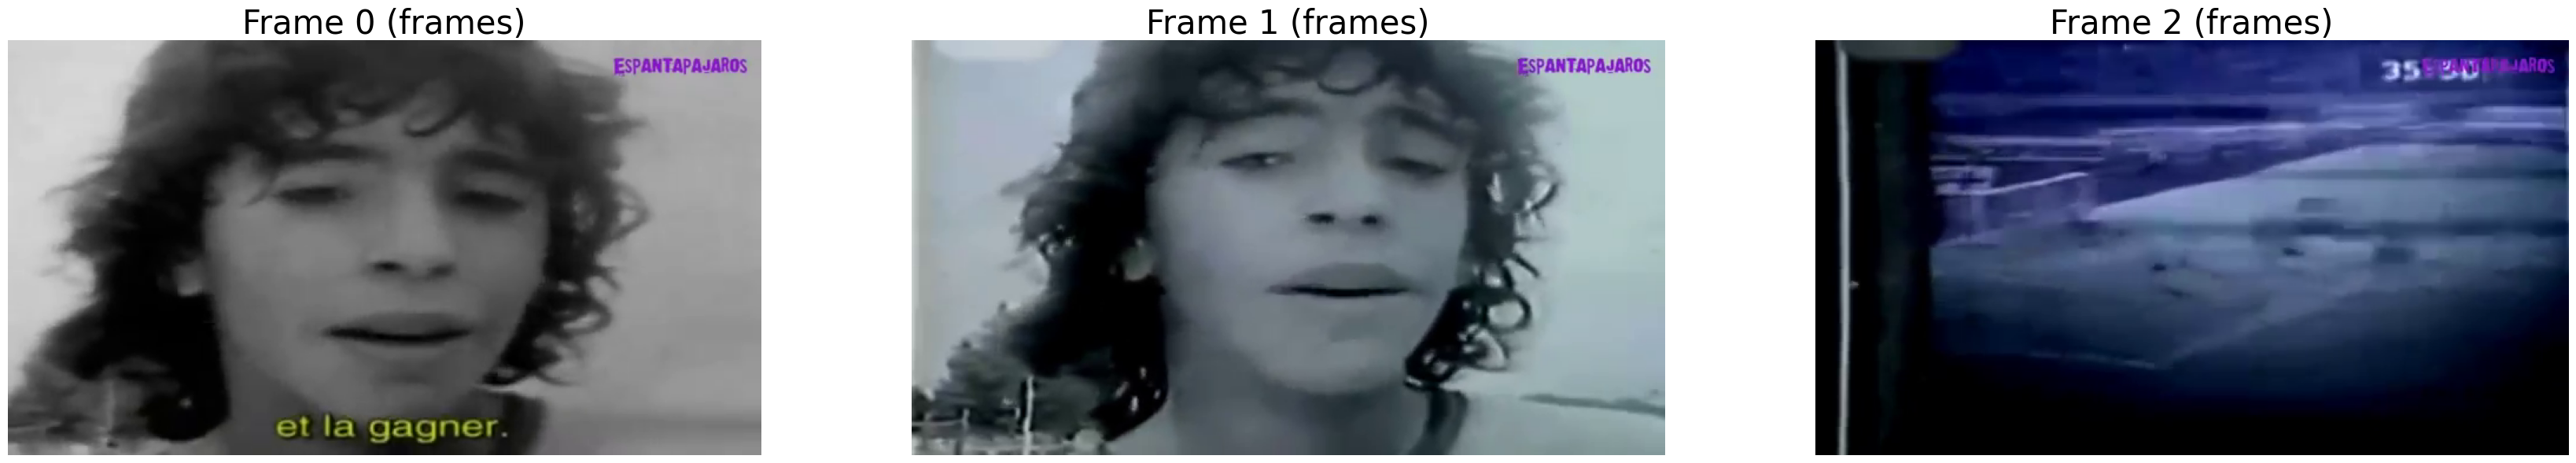

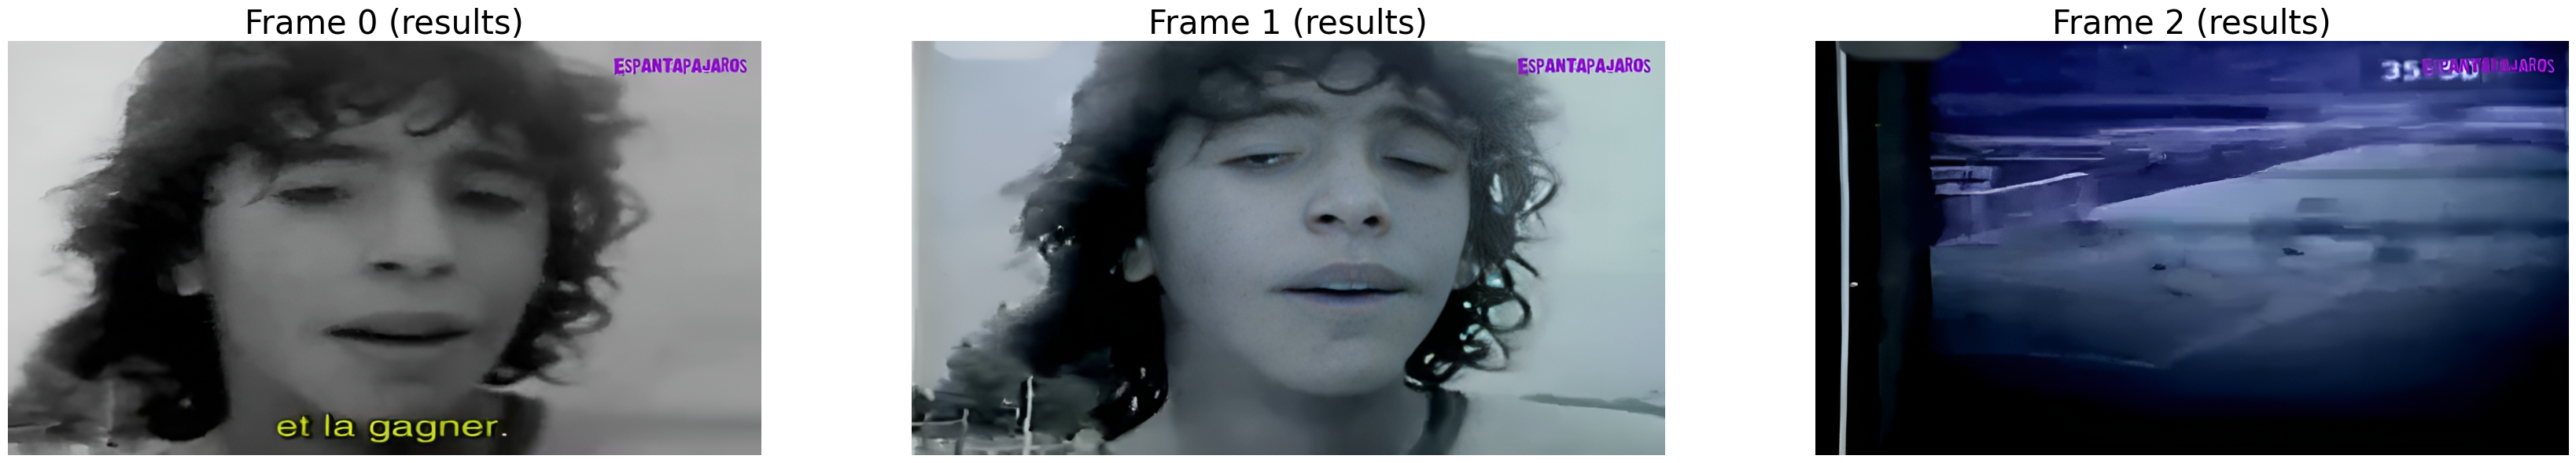

In [32]:
for image_folder in [original_frames, restored_frames]:
    img_list = []
    for path in image_folder[900:-1]:
        img_list.append(cv2.cvtColor(cv2.imread(f'{path}'), cv2.COLOR_BGR2RGB))
    display(img_list, f"{image_folder[0].split('/')[0]}")